In [1]:
import pynapple as nap
from pathlib import Path

# TUMOR paths [8]
# NP113_B1.nwb # has 0, 1, 2
# NP128_B1.nwb # has 0 and 1
# NP147_B1.nwb # has 0
# NP150_B1.nwb # has 0 and 1 ???

# EPILEPSY paths [9]
# NP119_B1.nwb # has 0, 1, 2
# NP134_B2.nwb # has 0, 1, 2, 3
# NP148_B2.nwb # has 0 
# NP149_B1.nwb # has 0

# make list of paths
# NOTE: 150 is not included bc there was no speech perception task... or at least its not annotated
nwb_paths = [
    Path("/data_store2/neuropixels/nwb/NP113_B1/NP113_B1.nwb"),
    Path("/data_store2/neuropixels/nwb/NP119_B1/NP119_B1.nwb"),
    Path("/data_store2/neuropixels/nwb/NP128_B1/NP128_B1.nwb"),
    Path("/data_store2/neuropixels/nwb/NP134_B2/NP134_B2.nwb"),
    Path("/data_store2/neuropixels/nwb/NP147_B2/NP147_B2.nwb"),
    Path("/data_store2/neuropixels/nwb/NP148_B2/NP148_B2.nwb"),
    Path("/data_store2/neuropixels/nwb/NP149_B1/NP149_B1.nwb"),
    Path("/data_store2/neuropixels/nwb/NP150_B1/NP150_B1.nwb"),
]

# make list of tumor ids and infiltrated id
tumor_ids = [1, 0, 1, 0, 1, 0, 0, 1]  

In [2]:
import fnmatch
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from scipy.linalg import norm
from scipy.stats import kstest
from scipy.stats import ttest_rel

# define variables to save out from loop
yield_list = []
fr_list = []
isi_list = []
cv2_list = []
cdf_list = []
peak_amp_list = []
ks_stats_list = []
tumor_id_list = []

# loop through all nwb files
for i in range(len(nwb_paths)):
    data = nap.load_file(nwb_paths[i])
    keys = data.keys()

    # find the spike TsGroup objects, number various based on recording apparatus
    template = "*imec*"
    keys = [key for key in keys if fnmatch.fnmatch(key, template)]
    template = "*KS4*"
    keys = [key for key in keys if fnmatch.fnmatch(key, template)]
    # Preferentially select keys containing 'Th='; if none, use all keys
    th_keys = [key for key in keys if "Th=" in key]
    if th_keys:
        keys = th_keys
    template = "*sentgen*" 
    keys = [key for key in keys if not fnmatch.fnmatch(key, template)]

    for s in range(len(keys)):
        spike_times = data[keys[s]]
        # print(spike_times)
        
        # 1. filter to good neurons
        firingRates_all = spike_times.metadata["rate"]
        task_times = data["TaskTimes"]
        beh_epochs = nap.IntervalSet(start=task_times.start, end=task_times.end)
        spike_times_beh = spike_times.restrict(beh_epochs)
        firingRates_beh = spike_times_beh.metadata["rate"]

        # calculate ks stats
        start_time = task_times.start
        end_time = task_times.end
        ks_stats = np.zeros(len(spike_times))
        ks_pvals = np.zeros(len(spike_times))
        # Create a list to store (spike_times_norm, cdf) tuples for each unit
        spike_norm_cdf_list = []
        for u in range(len(spike_times)):
            # get spike times for this unit
            test = spike_times_beh[u].as_series().index.values

            # The null hypothesis is that the spike times are uniformly distributed between start_time and end_time
            if len(test) > 1:
                min_time = start_time[0]
                max_time = end_time[-1]
                # Normalize spike times to [0, 1] for KS test against uniform
                normalized_spike_times = (test - min_time) / (max_time - min_time)
                spike_times_norm = np.sort(normalized_spike_times)
                cdf = np.arange(1, len(spike_times_norm)+1) / len(spike_times_norm)
                # Save (spike_times_norm, cdf) as a tuple for this unit
                spike_norm_cdf_list.append((spike_times_norm, cdf))
                ks_result = kstest(normalized_spike_times, 'uniform')
                ks_stats[u] = ks_result.statistic
                ks_pvals[u] = ks_result.pvalue
            else:
                ks_stats[u] = np.nan
                ks_pvals[u] = np.nan
                spike_norm_cdf_list.append((np.array([]), np.array([])))

        # now do ISI calculation
        violationThreshold = 3/1000 #for 3 ms isi refractory period, what used before, middle of range that kilosort cites
        violationPct = np.zeros(len(spike_times))
        cv_isi = np.zeros(len(spike_times))
        for u in range(len(spike_times)-1):
            unit = spike_times[u]
            unit = unit.as_series().index
            if len(unit) < 100:
                violationPct[u] = 1 
                cv_isi[u] = np.nan
            else:
                isi = unit.diff()[1:len(unit)]
                violations = np.where(isi<violationThreshold)
                violations = np.array(violations)
                violationPct[u] = violations.size/len(isi)
                cv_isi[u] = np.std(np.array(isi)) / np.mean(np.array(isi))
                

        # now apply masks
        KSLabels = spike_times.metadata["KSLabel"]
        firingRates = firingRates_beh
        mask1 = violationPct<3/100 # throwing out neurons with > 3% isi violations with isi = 3 ms; lose quite a bit with 5 ms esp when including cdf stats
        mask2 = firingRates>0.5 # firing rate > 0.5 ms during all behavior epochs
        mask3 = KSLabels!="noise" # not noise per auto label
        mask4 = ks_stats < 0.3 # KS stat < 0.3 (stability across recording)
        mask = mask1 & mask2 & mask3 & mask4
        indicesFinal = firingRates.index[mask]
        spike_times_good = spike_times_beh[indicesFinal]

        # calculate metrics to save out
        firing_rates_good = spike_times_good.metadata["rate"]
        violationPct_good = violationPct[indicesFinal]
        cv2_good = cv_isi[indicesFinal]
        peak_amp_good = spike_times_good.metadata["Amplitude"]
        ks_stats_good = ks_stats[indicesFinal]
        cdf_good = [spike_norm_cdf_list[i] for i in indicesFinal]


        # now save out all the data
        yield_list.append(len(spike_times_good))
        fr_list.append(firing_rates_good)
        isi_list.append(violationPct_good)
        cv2_list.append(cv2_good)
        ks_stats_list.append(ks_stats_good)
        cdf_list.append(cdf_good)
        peak_amp_list.append(peak_amp_good)
        tumor_id_list.append(tumor_ids[i])

/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/io/interface_nwb.py:133: UserWarning: Some starts and ends are equal. Removing 1 microsecond!
  data = nap.IntervalSet(df)
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/metadata_class.py:188: UserWarning: Metadata name 'Task name' contains a special character, and cannot be accessed as an attribute. Use 'get_info()' or key indexing to access metadata.
  warnings.warn(
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/io/interface_nwb.py:133: UserWarning: DataFrame is not sorted by start times. Sorting it.
  data = nap.IntervalSet(df)
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/metadata_class.py:188: UserWarning: Metadata name 'Task name' contains a special character, and cannot be accessed as an attribute. Use 'get_info()' or key indexing to access metadata.
  warnings.warn(
/userdata/ekato/miniforge3/envs/se2n

1552


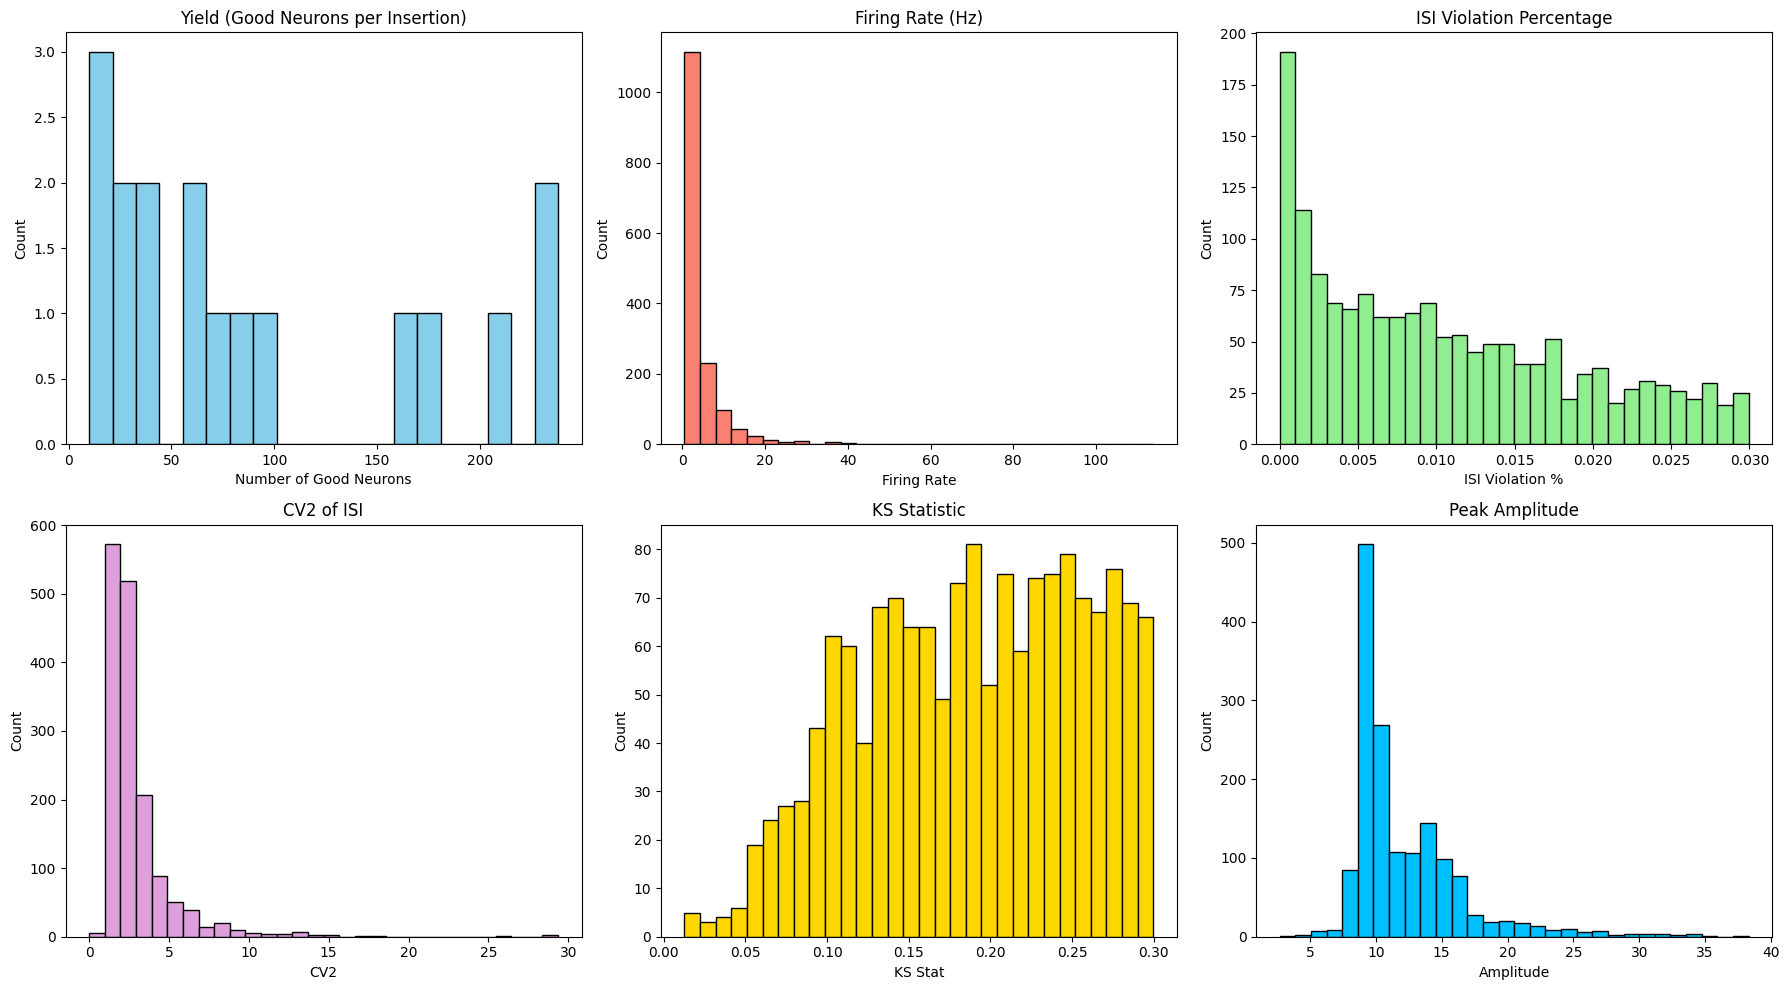

<Figure size 800x600 with 0 Axes>

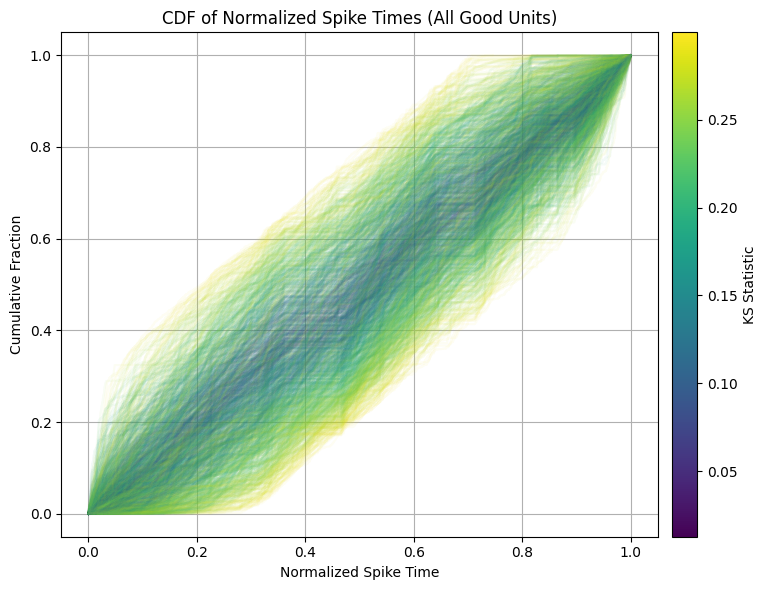

In [4]:
# now plot data
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Convert lists of arrays to flat arrays for histograms where appropriate
yield_arr = np.array(yield_list)
fr_arr = np.concatenate([np.array(x) for x in fr_list]) if len(fr_list) > 0 else np.array([])
isi_arr = np.concatenate([np.array(x) for x in isi_list]) if len(isi_list) > 0 else np.array([])
cv2_arr = np.concatenate([np.array(x) for x in cv2_list]) if len(cv2_list) > 0 else np.array([])
ks_stats_arr = np.concatenate([np.array(x) for x in ks_stats_list]) if len(ks_stats_list) > 0 else np.array([])
peak_amp_arr = np.concatenate([np.array(x) for x in peak_amp_list]) if len(peak_amp_list) > 0 else np.array([])

print(np.sum(yield_arr))

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

# Histogram of yield_list (number of good neurons per subject/insertion)
axs[0].hist(yield_arr, bins=20, color='skyblue', edgecolor='k')
axs[0].set_title('Yield (Good Neurons per Insertion)')
axs[0].set_xlabel('Number of Good Neurons')
axs[0].set_ylabel('Count')

# Histogram of firing rates
axs[1].hist(fr_arr, bins=30, color='salmon', edgecolor='k')
axs[1].set_title('Firing Rate (Hz)')
axs[1].set_xlabel('Firing Rate')
axs[1].set_ylabel('Count')

# Histogram of ISI violation percentage
axs[2].hist(isi_arr, bins=30, color='lightgreen', edgecolor='k')
axs[2].set_title('ISI Violation Percentage')
axs[2].set_xlabel('ISI Violation %')
axs[2].set_ylabel('Count')

# Histogram of CV2
axs[3].hist(cv2_arr[~np.isnan(cv2_arr)], bins=30, color='plum', edgecolor='k')
axs[3].set_title('CV2 of ISI')
axs[3].set_xlabel('CV2')
axs[3].set_ylabel('Count')

# Histogram of KS stats
axs[4].hist(ks_stats_arr, bins=30, color='gold', edgecolor='k')
axs[4].set_title('KS Statistic')
axs[4].set_xlabel('KS Stat')
axs[4].set_ylabel('Count')

# Histogram of Peak Amplitude
axs[5].hist(peak_amp_arr, bins=30, color='deepskyblue', edgecolor='k')
axs[5].set_title('Peak Amplitude')
axs[5].set_xlabel('Amplitude')
axs[5].set_ylabel('Count')

plt.tight_layout()
plt.show()

# CDF plot for all neurons in cdf_list
plt.figure(figsize=(8, 6))
plotted_any = False  # Track if any data is actually plotted

# cdf_list contains lists of tuples, so we need to iterate through each list first


# Flatten cdf_list and ks_stats_list to match up each cdf with its kstat.
flat_cdf_tuples = []
flat_kstats = []

for insertion_cdf_list, insertion_ks_stats in zip(cdf_list, ks_stats_list):
    for cdf_tuple, kstat in zip(insertion_cdf_list, insertion_ks_stats):
        flat_cdf_tuples.append(cdf_tuple)
        flat_kstats.append(kstat)

# Normalize kstats for colormap
if len(flat_kstats) > 0:
    kstat_arr = np.array(flat_kstats)
    kstat_min, kstat_max = np.nanmin(kstat_arr), np.nanmax(kstat_arr)
    norm = mpl.colors.Normalize(vmin=kstat_min, vmax=kstat_max)
    cmap = plt.get_cmap('viridis')
else:
    norm = None
    cmap = None

plotted_any = False

fig, ax = plt.subplots(figsize=(8, 6))

for cdf_tuple, kstat in zip(flat_cdf_tuples, flat_kstats):
    if (
        isinstance(cdf_tuple, tuple)
        and len(cdf_tuple) == 2
        and isinstance(cdf_tuple[0], (np.ndarray, list))
        and isinstance(cdf_tuple[1], (np.ndarray, list))
        and len(cdf_tuple[0]) > 0
        and len(cdf_tuple[1]) > 0
    ):
        norm_spikes, cdf = np.array(cdf_tuple[0]), np.array(cdf_tuple[1])
        if norm_spikes.shape[0] == cdf.shape[0]:
            color = cmap(norm(kstat)) if (cmap is not None and norm is not None) else None
            ax.step(norm_spikes, cdf, where='post', alpha=0.05, color=color)
            plotted_any = True

if not plotted_any:
    ax.text(0.5, 0.5, 'No CDF data to display', ha='center', va='center', fontsize=14)
else:
    # Add colorbar to the right of the plot
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label('KS Statistic')

ax.set_xlabel('Normalized Spike Time')
ax.set_ylabel('Cumulative Fraction')
ax.set_title('CDF of Normalized Spike Times (All Good Units)')
ax.grid(True)
fig.tight_layout()
plt.show()